# Robotics and Machine Vision – Image Warping Lab

Last edited for May-June 2023 

This lab will explore image warping.

You should download the **supporting images** `mona.jpg` and `windows.jpg` from the assignment's webpage, and put them into the same directory as this notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Make figures larger.
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
%config InlineBackend.figure_format = 'retina'


## 1. Forward mapping [15 marks]

Let us start by implementing image warping using forward mapping.
Every pixel in the source image is transformed to the target image independently. You will see that this approach leads to gaps between the transformed pixels in the target image.

Let's first load the image and define an example warping transformation for this assignment:

In [3]:
source = plt.imread('mona.jpg') / 255.

## Basic transformations to manipulate the source image.
T = np.array([[1, 0, -source.shape[1] / 2],
              [0, 1, -source.shape[0] / 2],
              [0, 0, 1]])
t = np.pi / 4
R = np.array([[np.cos(t), -np.sin(t), 0],
              [np.sin(t),  np.cos(t), 0],
              [ 0, 0, 1]])
S = np.diag([2, 2, 1])

## The warping transformation (rotation about arbitrary point).
M = np.linalg.inv(T) @ R @ S @ T

<span style="color:red"> **For you to do:** </span>

**a) Implement a function to transform a point (x, y) using a homogeneous 2D transform matrix. [5 marks]**

In [4]:
def transform_pixel_nn(x, y, transform):
    """Transforms a source pixel coordinate (x, y) using 'transform', and rounds to the nearest pixel,
    coordinate. Returns a tuple (x', y')."""
    ##  Replace this code with your own implementation.
    transform_pixel_nn_matrix = transform @ np.array([x, y, 1]).T # np.shape -> (3,0)
    x_transf = max(min(transform_pixel_nn_matrix[0], 511),0)
    y_transf = max(min(transform_pixel_nn_matrix[1], 511),0)
    result_tuple = tuple([x_transf, y_transf])
    
    return  result_tuple # (0, 0)"

<span style="color:red"> **For you to do:** </span>

**b) Implement forward mapping using your per-pixel transform function. [10 marks]**

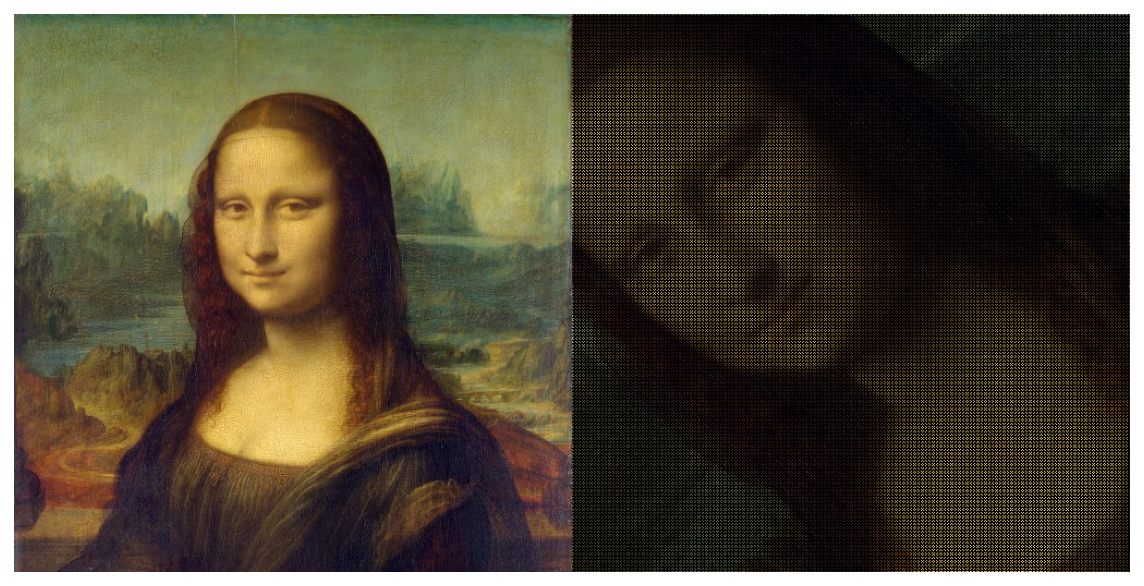

In [5]:
def forward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using forward mapping."""
    ## Replace this code with your own implementation.
    forward_mapping_image = np.zeros_like(source)
    # in forward mapping we iterate over the source image 
    for source_y in range(source.shape[1]):
        for source_x in range(source.shape[0]):
            # for every source position of the pixel p it returns the new position of the same pixel when the transformation has been applied
            target_x = round(transform_pixel_nn(source_x, source_y, transform)[0])
            target_y = round(transform_pixel_nn(source_x, source_y, transform)[1])
            # colouring in the target image pixel at p′ with the colour of pixel p in the source image
            if 0 <= target_y < forward_mapping_image.shape[1] and 0 <= target_x < forward_mapping_image.shape[0]:
                forward_mapping_image[target_x, target_y, :] = source[source_x, source_y, :]
            
    return forward_mapping_image # np.zeros_like(source)



## Visualise input (left) and warped output (right).
target = forward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");


## 2. Backward mapping [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) Using the `transform_pixel_nn` function from your implementation of forward mapping implement backward mapping in the code cell below using the same 2D transformation `M`.**

Backward mapping computes for each **target image pixel** where in the source image it originats from, and, in its simplest form, uses the colour sampled from the nearest pixel. Note that this operation should not leave any gaps in the warped image.

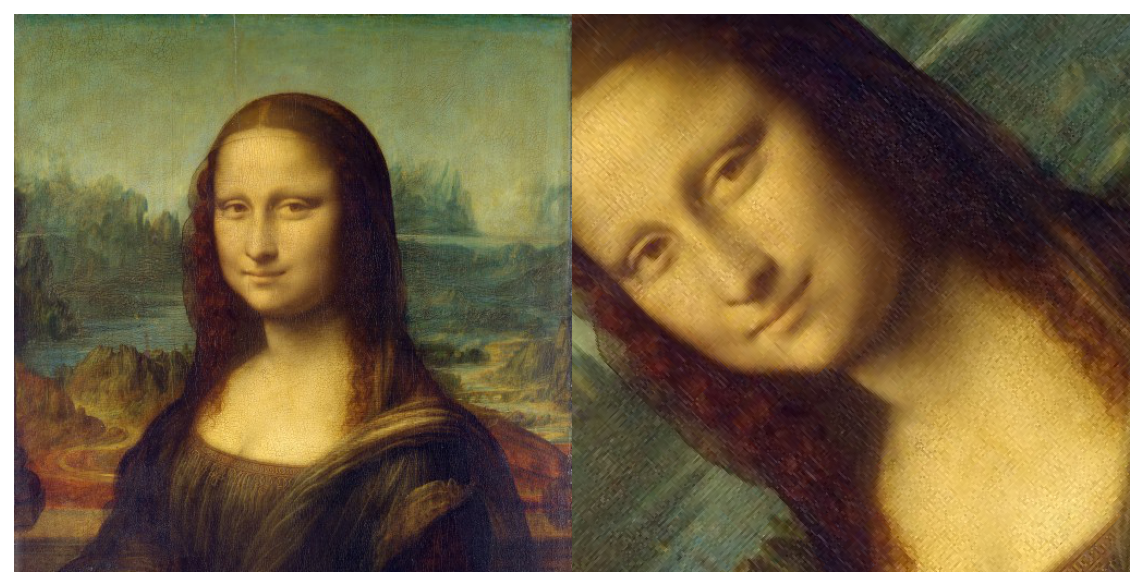

In [6]:
def backward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with nearest-neighbour interpolation.
    ## Replace this code with your own implementation.. """ 
    backward_mapping_image = np.zeros_like(source)
    # in backward mapping we iterate over the target image 
    for target_y in range(backward_mapping_image.shape[1]):
        for target_x in range(backward_mapping_image.shape[0]):
            # by using the inverse of the transform matrix we can transform the target image to get the source one
            source_x = round(transform_pixel_nn(target_x, target_y, np.linalg.inv(transform))[0])
            source_y = round(transform_pixel_nn(target_x, target_y, np.linalg.inv(transform))[1])
            if 0 <= source_y < source.shape[1] and 0 <= source_x < source.shape[0]:
                backward_mapping_image[target_x, target_y, :] = source[source_x, source_y, :]

    return backward_mapping_image


## Visualise input (left) and warped output (right).
target = backward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");

## 3. Linear interpolation [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) In the code cell below, extend your backward mapping function from part 2 to sample pixel colours from the source image using bilinear interpolation. [15 marks]**

**b) Handle the edge cases carefully for full marks. Specifically, implement the "fading to black" effect at the edges of the interpolated image by carefully considering how to handle the off-the-image grid pixels of the source image during interpolation. [5 marks]**

**Hint:** For validation, it may be helpful to use the transformations `M` commented out in the code cell below.

Interpolation must be implemented from scratch, not using any exisiting library functions.

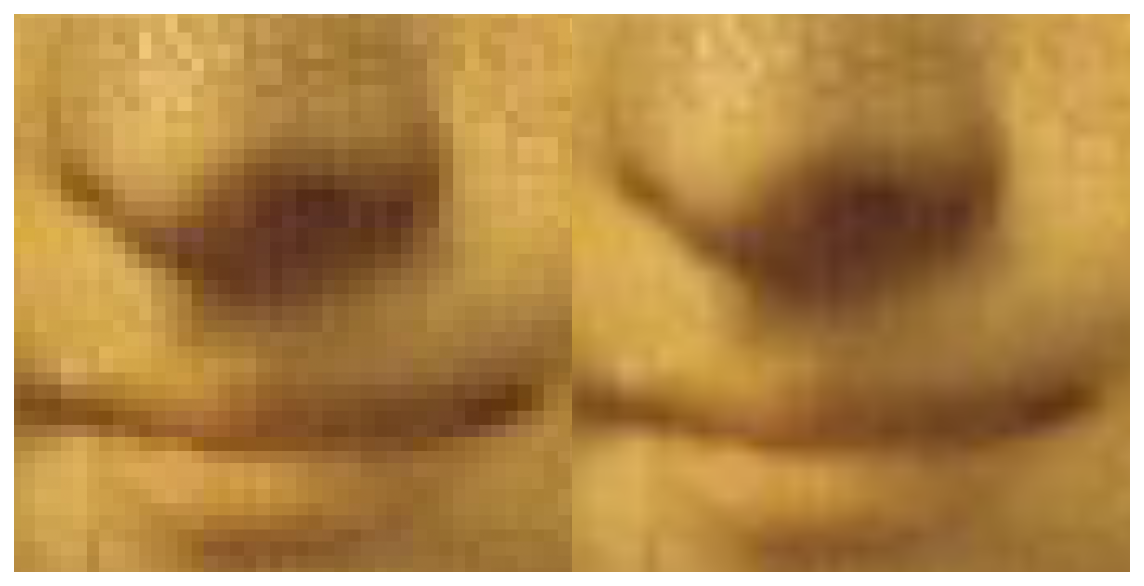

In [7]:
def backward_mapping_bilinear(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with bilinear interpolation."""
    ## Replace this code with your own implementation to satify 3a and 3b
    backward_mapping_image = np.zeros_like(source)
    for target_y in range(backward_mapping_image.shape[1]):
        for target_x in range(backward_mapping_image.shape[0]):
            source_x = transform_pixel_nn(target_x, target_y, np.linalg.inv(transform))[0]
            source_y = transform_pixel_nn(target_x, target_y, np.linalg.inv(transform))[1]
            #Check the bounds of the inverse pts we got and if they lie in the original image,
            #then copy the color from that original pt to the new matrix/image.
            if 0 <= source_y < source.shape[1] and 0 <= source_x < source.shape[0]:
                x0 = int(np.floor(source_x))
                x1 = x0 + 1
                y0 = int(np.floor(source_y))
                y1 = y0 + 1
                # pixels from the source image with their colours
                pixel_bl = source[x0, y0]
                pixel_br = source[x1, y0]
                pixel_tl = source[x0, y1]
                pixel_tr = source[x1, y1]

                R1 = pixel_bl * (x1-source_x)/(x1-x0) + pixel_br * (source_x-x0)/(x1-x0) 
                R2 = pixel_tl * (x1-source_x)/(x1-x0) + pixel_tr * (source_x-x0)/(x1-x0) 

                backward_mapping_image[target_x, target_y, :] = R1 * (y1-source_y)/(y1-y0) + R2 * (source_y-y0)/(y1-y0)
            else:
                backward_mapping_image[target_x, target_y, :] = [0, 0, 0]

    return backward_mapping_image


## Compare nearest-neighbour (left) and bilinear interpolation (right) side by side.
M = np.array([[12, 0, -2486], [0, 12, -2508], [0, 0, 1]])  # big smile
#M = np.array([[40, 0, 80], [0, 40, 80], [0, 0, 1]])  # check edge handling
target_nearest  = backward_mapping(source, M)
target_bilinear = backward_mapping_bilinear(source, M)
plt.imshow(np.hstack([target_nearest, target_bilinear]))
plt.axis("off");


## 4. Lens undistortion [45 marks]

In this part of the assignment, you will apply a different warping function, speficifically one that can be used to remove lens distortion from images. The visual effect of such *un-*distortion is rectification of lines so that they appear straight again.

Undistortion is to be implemented via backward mapping. To this end, consider the steps to map a target image location $(u,v)$ onto the source image location $(u', v')$ using the *polynomial lens distortion model*:

$$\begin{align}
x &= (u - p_x) / f_x \\
y &= (v - p_y) / f_y \\
r^2 &= x^2 + y^2 \\
x' &= x \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y' &= y \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
u' &= x' \cdot f_x + p_x \\
v' &= y' \cdot f_y + p_y
\end{align}$$

In the mapping above:
* $f_x$ and $f_y$ are the focal lengths of the camera
* $(p_x, p_y)$ is called the *principal point* or *centre of projection*
* $k_1$, $k_2$, $k_3$ are the *lens distortion coefficients*

Further please note that:
* The `camera_matrix` is defined as:

  $\mathbf{K} = \begin{bmatrix}f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1\end{bmatrix}$.
  

* `dist_coeffs` is the lens distortion coefficients $\begin{bmatrix}k_1 & k_2 & k_3\end{bmatrix}$ .

<span style="color:red"> **For you to do:** </span>

**a) Implement the steps of the polynomial distortion model detailed above in the function below to calculate the source image location $(u', v')$  for a single given pixel $(u,v)$ of the target (undistorted) image. [5 marks]**



In [8]:
def undistort_point(u, v, camera_matrix, dist_coeffs):
    """Given camera matrix and distortion coefficients, finds the corresponding undistorted (source) pixel location (u', v') 
    for a given (target) pixel location (u,v)."""
    ## Replace this code with your own implementation.
    # Based on the provided polynomial lens distortion model,
    # correctly implement a function that returns the pixel location in
    # the source image corresponding a pixel (u,v) in the (undistorted)
    # target image for a given camera matrix and lens distortion coefficients.
    x, y, _ = np.linalg.inv(camera_matrix) @ np.array([u, v, 1])
    r_square = x**2 + y**2
    dist_coeffs_x = x * dist_coeffs
    dist_coeffs_y = y * dist_coeffs
    x_y = np.array([[x],[y]])
    x_y_K = np.insert([[dist_coeffs_x[0], dist_coeffs_x[1], dist_coeffs_x[2]],
                       [dist_coeffs_y[0], dist_coeffs_y[1], dist_coeffs_y[2]]], [3], x_y, axis=1)
    x_y_signed_small = x_y_K @ np.array([[r_square], [pow(r_square,2)], [pow(r_square,3)], [1]])
    x_y_signed = np.insert(x_y_signed_small, [2], [[1]], axis=0)
    u_v_signed = camera_matrix @ x_y_signed

    result_tuple = tuple([u_v_signed[0], u_v_signed[1]])

    return result_tuple # 0, 0"    
    


<span style="color:red"> **For you to do:** </span>

**b) Using your function `undistort_point` above, in the code cell below implement polynomial lens undistortion for a given image via backward mapping with bilinear interpolation. [15 marks]**


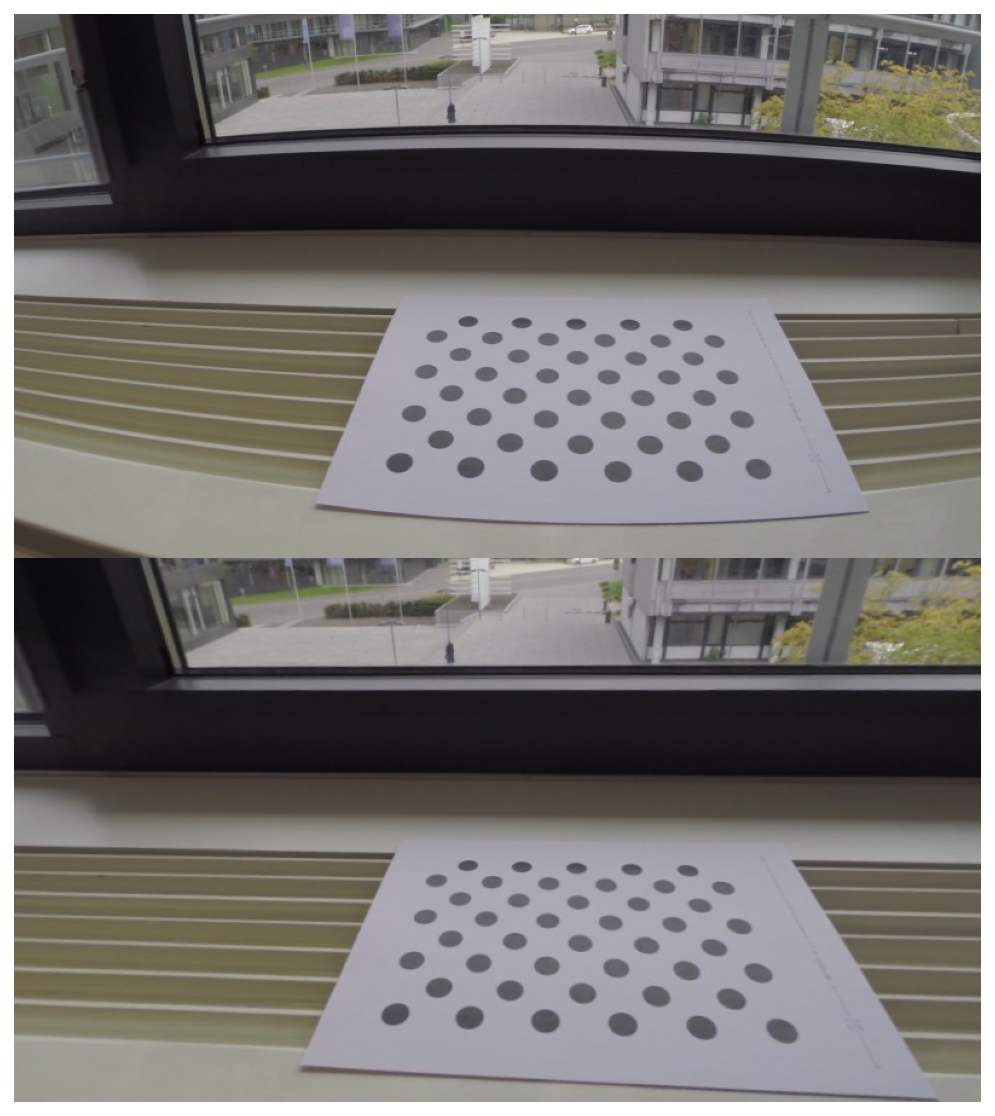

In [9]:
def undistort_image(image, camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients."""
    ## Replace this code with your own implementation.
    backward_mapping_image = np.zeros_like(image)
    # u, v are the pixels positions of the Target image
    for target_y in range(backward_mapping_image.shape[1]):
        for target_x in range(backward_mapping_image.shape[0]):
            # u', v' are the pixels positions of the Source image
            source_x = undistort_point(target_y, target_x, camera_matrix, dist_coeffs)[1]
            source_y = undistort_point(target_y, target_x, camera_matrix, dist_coeffs)[0]
            #Check the bounds of the inverse pts we got and if they lie in the original image,
            #then copy the color from that original pt to the new matrix/image.
            if 0 <= source_y < image.shape[1] and 0 <= source_x < image.shape[0]:
                x0 = int(np.floor(source_x))
                x1 = x0 + 1
                y0 = int(np.floor(source_y))
                y1 = y0 + 1
                # pixels from the source image with their colours
                pixel_bl = image[x0, y0]
                pixel_br = image[x1, y0]
                pixel_tl = image[x0, y1]
                pixel_tr = image[x1, y1]

                R1 = pixel_bl * (x1-source_x)/(x1-x0) + pixel_br * (source_x-x0)/(x1-x0)
                R2 = pixel_tl * (x1-source_x)/(x1-x0) + pixel_tr * (source_x-x0)/(x1-x0)

                backward_mapping_image[target_x, target_y] = R1 * (y1-source_y)/(y1-y0) + R2 * (source_y-y0)/(y1-y0)

    return backward_mapping_image # np.zeros_like(image)


## The intrinsic camera matrix and lens undistortion coefficients for the test image.
source = plt.imread('window.jpg') / 255.
camera_matrix = np.array([[474.53, 0, 405.96], [0, 474.53, 217.81], [0, 0, 1]])
dist_coeffs = np.array([-0.27194, 0.11517, -0.029859])

## Visualise input (top) and undistorted output (bottom).
target = undistort_image(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target]))
plt.axis("off");

<span style="color:red"> **For you to do:** </span>

**c) Implement fast image undistortion using vectorisation, without any for-loops. Your function should run in less than 3 seconds. [25 marks]**

Remember that the vectorised version of your undistortion function must be functionally identical to the original. This means the function must also perform bilinear interpolation.


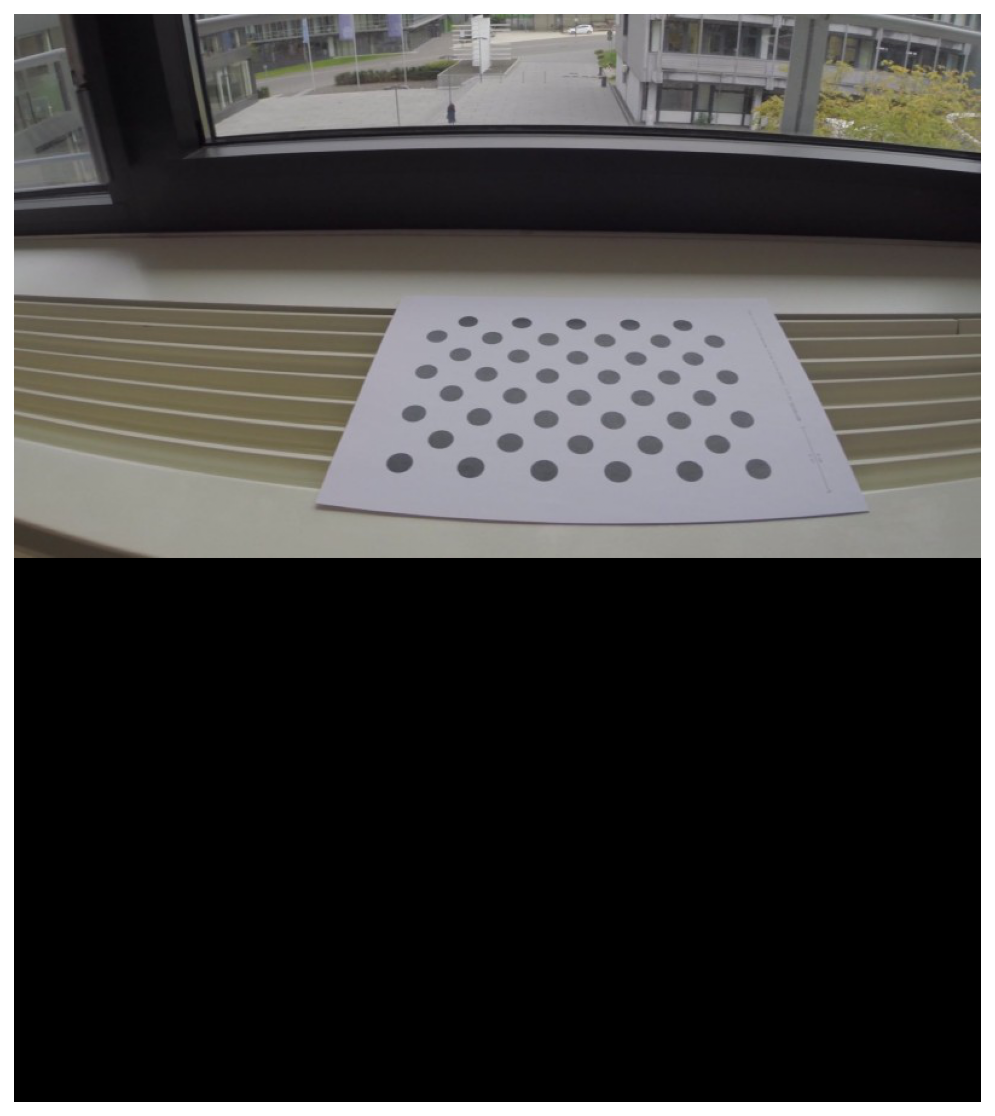

In [10]:
def undistort_image_vectorised(image, camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients.
    Use vectorised operations to avoid slow for-loops."""
    ## Replace this code with your own implementation.
    
    return np.zeros_like(image)


# Visualise input (top) and undistorted output (bottom).
target = undistort_image_vectorised(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target]))
plt.axis("off");